In [70]:

import tensorflow as tf
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Sequential
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt


In [71]:
batch_size = 256
img_height = 180
img_width = 180

In [72]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  directory = "./Data/TrainVal",
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1403 files belonging to 2 classes.
Using 1123 files for training.


In [73]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  directory = "./Data/TrainVal",
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1403 files belonging to 2 classes.
Using 280 files for validation.


In [74]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    directory="./Data/Test",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)


Found 154 files belonging to 2 classes.


In [75]:
class_names = train_ds.class_names
print(class_names)

['defected', 'no_defected']


In [76]:
num_classes = len(class_names)
print(num_classes)

2


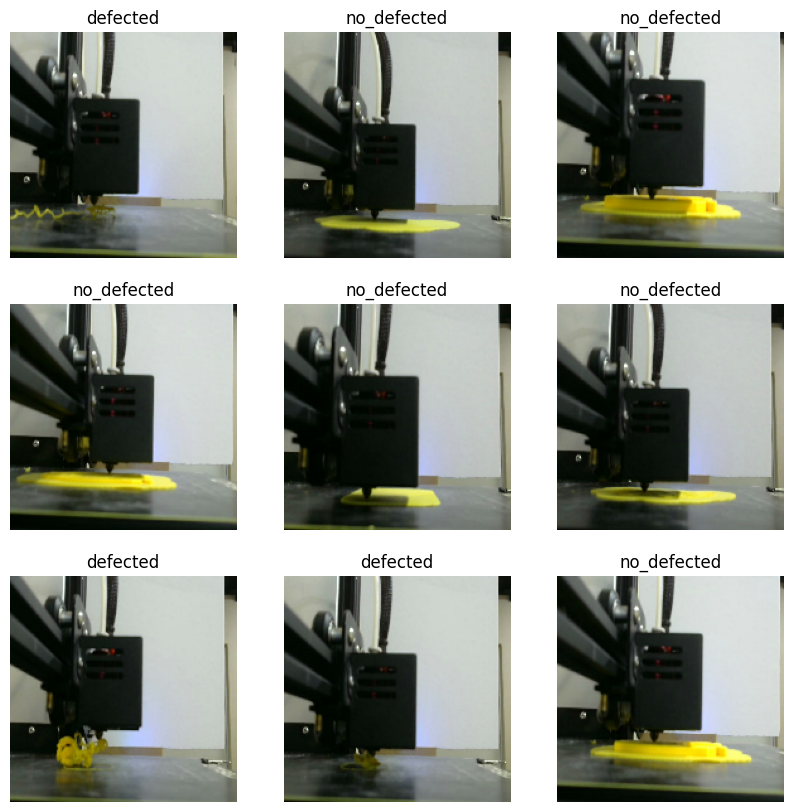

In [77]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [78]:

# Data Augmentation
data_augmentation = Sequential([
    layers.RandomFlip("horizontal", input_shape=(180, 180, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

# Normalization Layer
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))


c:\Users\Charbel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [79]:

def create_model():
    # Model definition with L2 regularization
    model = Sequential([
        data_augmentation,
        layers.Conv2D(16, 3, padding='same', activation='leaky_relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, padding='same', activation='leaky_relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding='same', activation='leaky_relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(2, activation="sigmoid", name="outputs")
    ])
    return model


In [80]:

def compile_model(model):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
    )
    return model


In [81]:

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,  # Increase patience to 10
        restore_best_weights=True
    )
]


In [82]:

# Define number of splits for K-Fold
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Arrays to store fold metrics
acc_per_fold = []
loss_per_fold = []
fold_no = 1


In [83]:
# Convert TensorFlow dataset to NumPy arrays
images, labels = [], []
for img_batch, label_batch in train_ds.as_numpy_iterator():
    images.extend(img_batch)
    labels.extend(label_batch)

images = np.array(images)
labels = np.array(labels)


In [84]:
from sklearn.model_selection import StratifiedKFold

# Define StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1
acc_per_fold = []
loss_per_fold = []
histories = []

for train_index, val_index in skf.split(images, labels):
    print(f"Training Fold {fold_no}")

    # Use indices to slice data
    train_images, val_images = images[train_index], images[val_index]
    train_labels, val_labels = labels[train_index], labels[val_index]

    # Create TensorFlow datasets
    train_fold = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).batch(128).prefetch(tf.data.AUTOTUNE)
    val_fold = tf.data.Dataset.from_tensor_slices((val_images, val_labels)).batch(128).prefetch(tf.data.AUTOTUNE)

    # Create and compile a fresh model for this fold
    model = create_model()
    model = compile_model(model)

    # Train the model
    history = model.fit(
        train_fold,
        validation_data=val_fold,
        epochs=30,
        batch_size=128,
    )
    histories.append(history)

    # Evaluate on the validation fold
    scores = model.evaluate(val_fold)
    acc_per_fold.append(scores[1])
    loss_per_fold.append(scores[0])

    print(f"Fold {fold_no}: Accuracy = {scores[1]:.4f}, Loss = {scores[0]:.4f}")
    fold_no += 1

# Report average metrics
print(f"Average accuracy across folds: {np.mean(acc_per_fold):.4f}")
print(f"Average loss across folds: {np.mean(loss_per_fold):.4f}")


Training Fold 1
Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 279ms/step - accuracy: 0.4822 - loss: 1.2184 - val_accuracy: 0.5200 - val_loss: 0.6713
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 256ms/step - accuracy: 0.5478 - loss: 0.6661 - val_accuracy: 0.7467 - val_loss: 0.6379
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 249ms/step - accuracy: 0.6722 - loss: 0.6250 - val_accuracy: 0.8133 - val_loss: 0.5630
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.7390 - loss: 0.5770 - val_accuracy: 0.7422 - val_loss: 0.5823
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 254ms/step - accuracy: 0.7428 - loss: 0.5200 - val_accuracy: 0.7600 - val_loss: 0.5719
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 245ms/step - accuracy: 0.7618 - loss: 0.5183 - val_accuracy: 0.8044 - val_loss: 0.4587
Epoch 7/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 246ms/step - accuracy: 0.7831 - loss: 0.4906 - val_accuracy: 0.8356 - val_loss: 0.4149
Epoch 8/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 246ms/step - accuracy: 0.8428 - loss: 0.3917 - val_accuracy: 0.84

In [85]:

# Calculate and report average metrics
print(f"Average accuracy across folds: {np.mean(acc_per_fold):.4f}")
print(f"Average loss across folds: {np.mean(loss_per_fold):.4f}")


Average accuracy across folds: 0.8896
Average loss across folds: 0.2616


Best Fold: Fold 2
Accuracy: 0.9200, Loss: 0.2086


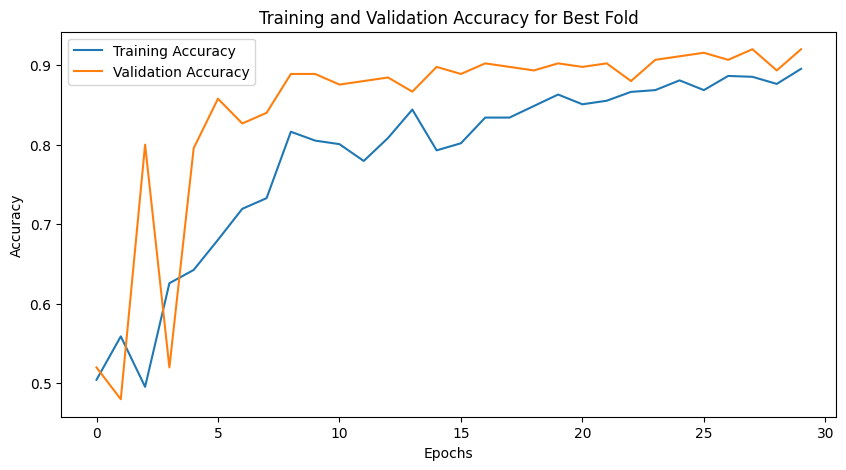

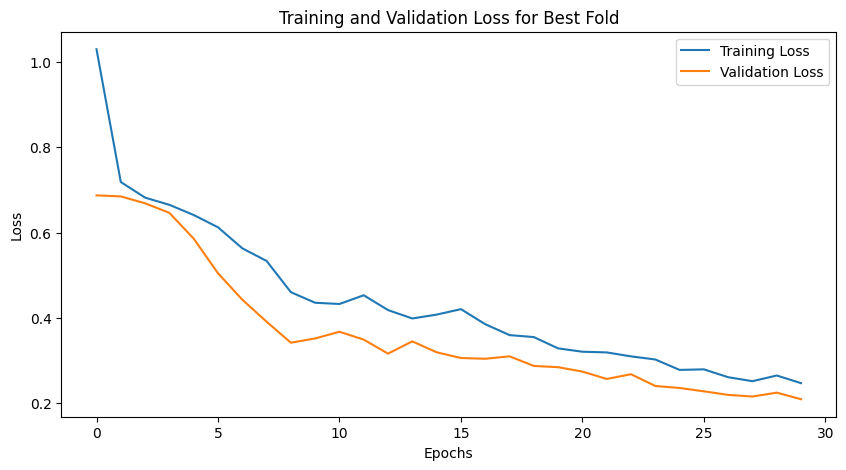

In [86]:
# Identify the best fold based on accuracy
best_fold_idx = np.argmax(acc_per_fold)  # Index of the best fold
print(f"Best Fold: Fold {best_fold_idx + 1}")
print(f"Accuracy: {acc_per_fold[best_fold_idx]:.4f}, Loss: {loss_per_fold[best_fold_idx]:.4f}")

# Plot training metrics for the best fold
history_dict = histories[best_fold_idx].history  # Assuming you store each fold's history in a list

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy for Best Fold')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss for Best Fold')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
